In [1]:
import psycopg2
import pandas as pd

In [2]:
df = pd.read_json("Car/arabam/car_data.json").head()

In [3]:
df.price = df.price.apply(lambda x:x.replace('.','')).astype(int)

### Create `araba` table in DB

In [4]:
# conn = psycopg2.connect("dbname=car user=postgres password=1234")
# cur = conn.cursor()
# command = (
#         """
#         CREATE TABLE araba (
#             Car_id INTEGER PRIMARY KEY,
#             Model VARCHAR(255) NOT NULL,
#             Year INTEGER NOT NULL,
#             Km FLOAT NOT NULL,
#             Color VARCHAR(255) NOT NULL,
#             Price INTEGER NOT NULL,
#             Province VARCHAR(255)
#         )
#         """)
# cur.execute(command)
# cur.close()
# conn.commit()
# conn.close()

### Insert dataframe into DB

In [5]:
# conn = psycopg2.connect('dbname=car user=postgres password=1234')
# cur = conn.cursor()

# records = df.to_dict('record')
# sql = 'INSERT INTO araba VALUES (%s, %s, %s, %s, %s, %s, %s)'
# for i,v in enumerate(records):
#     cur.execute(sql, (i, v['model'], v['year'], v['km'], v['color'], v['price'], v['province']))
# cur.close()
# conn.commit()
# conn.close()

### Create a Dashboard

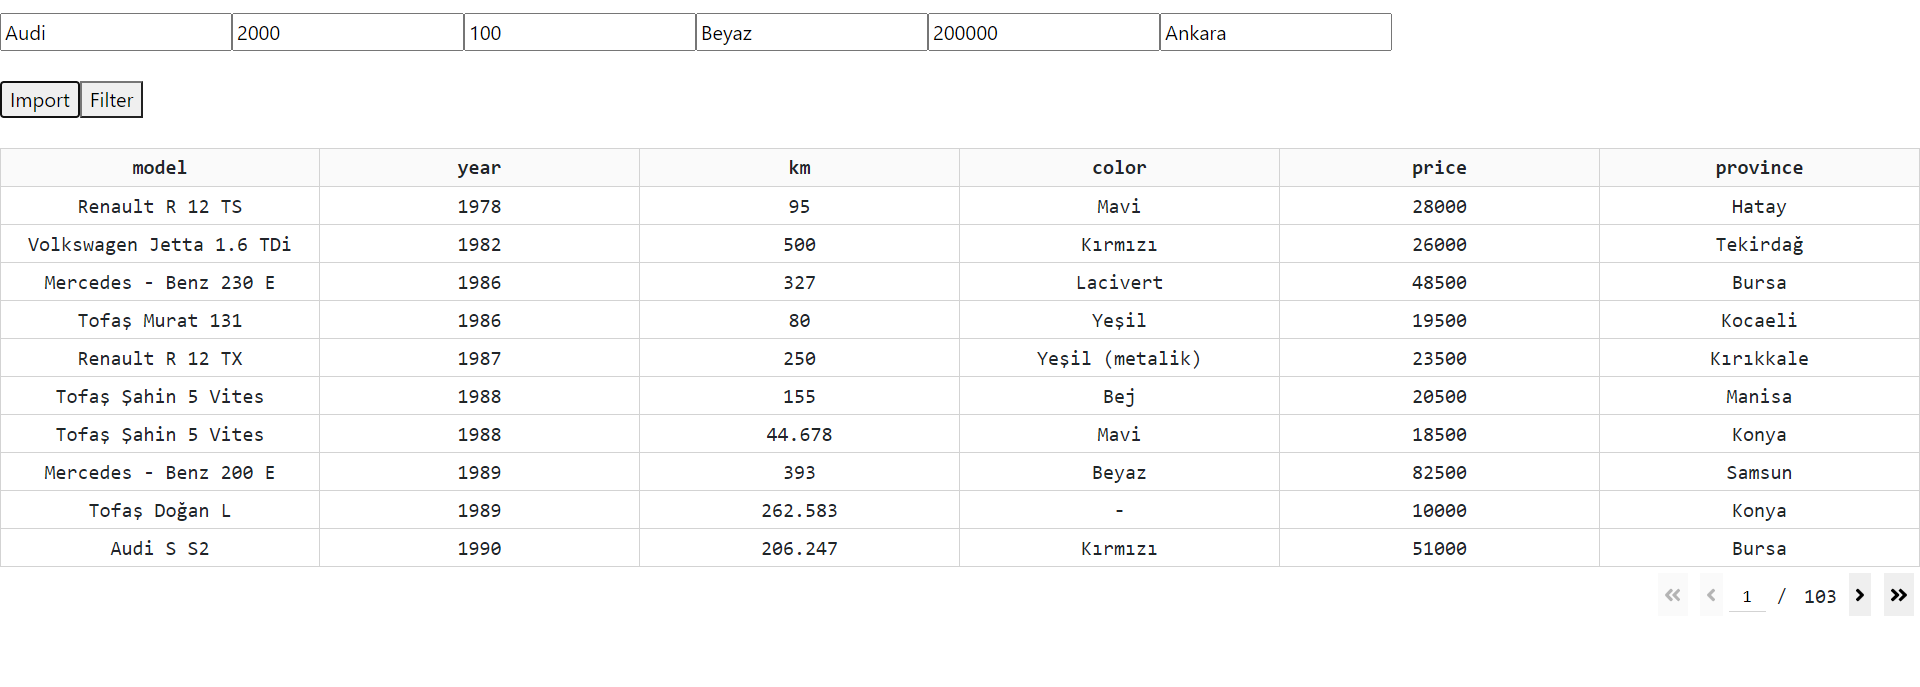

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Output, Input, State
import dash_bootstrap_components as dbc
import plotly.graph_objects as go

import pandas as pd
import psycopg2
import pandas.io.sql as sqlio

def get_database(click=0, model='', year=0, km=1000000, color='', price=10000000, province=''):
    global df_all, df_filtered

    conn = psycopg2.connect("dbname=car user=postgres password=1234")
    cur = conn.cursor()
    
    # --All cars
    query_1 = f"select model, year, km, color, price, province from araba order by year asc;"
    
    cur.execute(query_1)
    the_data = cur.fetchall()
    df_all = pd.DataFrame(the_data, columns=[desc[0] for desc in cur.description])
    
    if model is None:
        model=''
    if year is None:
        year=0
    if km is None:
        km=1000000
    if color is None:
        color=''
    if price is None:
        price=10000000
    if province is None:
        province=''

    if click>0:
    # according to model, year, km, color, price, province
        query_2= f"select model, year, km, color, price, province from araba where (model LIKE '%{model}%') and (year>={year}) and (km<={km}) and (color LIKE '{color}%') and (price<={price}) and (province LIKE '{province}%') order by price asc;"

        cur.execute(query_2)
        the_data = cur.fetchall()
        df_filtered= pd.DataFrame(the_data, columns=[desc[0] for desc in cur.description])
    else:
        pass

    cur.close()
    conn.close()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
                html.Br(),
                dcc.Input(id='model', type='text', placeholder='Model'),
                dcc.Input(id='year', type='number', placeholder='Year'),
                dcc.Input(id='km', type='number', placeholder='km'),
                dcc.Input(id='color', type='text', placeholder='Color'),
                dcc.Input(id='price', type='number', placeholder='Price'),
                dcc.Input(id='province', type='text', placeholder='Province'),
                html.Br(),
                html.Br(),
                html.Button('Import', id='import', n_clicks=0),
                html.Button('Filter', id='filter', n_clicks=0),
                html.Br(),
                html.Br(),
                html.Div(id='place')
])


## Callback fonksiyonu
@app.callback(
    Output(component_id='place', component_property='children'),
    [Input(component_id='import', component_property='n_clicks'),
    Input(component_id='filter', component_property='n_clicks'),
    Input(component_id='province', component_property='n_clicks')],
    [State(component_id='model', component_property='value'),
     State(component_id='year', component_property='value'),
     State(component_id='km', component_property='value'),
     State(component_id='color', component_property='value'),
     State(component_id='price', component_property='value'),
     State(component_id='province', component_property='value')]
)


def save(n_clicks1, n_clicks2, n_clicks3, value1, value2, value3, value4, value5, value6):
    global df_all, df_filtered
    
    ctx = dash.callback_context
    button = ctx.triggered[0]['prop_id'].split('.')[0]
    
    data_table = None
    
    if n_clicks1>0:
        if button == 'import':
            get_database(0, value1, value2, value3, value4, value5, value6)
            dat = df_all

        elif button == 'filter':
            get_database(n_clicks2, value1, value2, value3, value4, value5, value6)
            dat = df_filtered
        
        data_table = dash_table.DataTable(
                    id='table_all',
                    data=dat.to_dict('records'),
                    columns=[{'id': c, 'name': c} for c in dat.columns],
                    style_cell={'textAlign': 'center', 'width': '100px', 'minWidth': '100px', 'maxWidth': '100px'},
                    fixed_rows={'headers': True, 'data': 0},
                    style_header={'fontWeight': 'bold'},
                    page_size=10,
                    selected_rows=[],
                    style_table={'overflowX': 'auto'},
                    editable=True )

    return [data_table]
                            
if __name__ == '__main__':
    app.run_server()  

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Apr/2021 21:13:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:25] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:25] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:28] "GET /_dash-component-suites/dash_table/async-highlight.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:28] "GET /_dash-component-suites/dash_table/async-table.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2021 21:13:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - 